In [1]:
import os
import glob
from tensorflow.keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.util.shape import view_as_windows
from skimage.draw import circle, line, set_color
import numpy as np
import scipy.cluster.hierarchy as hcluster
import math

In [2]:
def evaluation_pipeline():
    input_file = glob.glob("./input/*.jpg")
    output_dir = "./output/data/"
    print(input_file)
    for file in input_file:
        img1 = imread(file).astype(np.uint8)[:,:,:3]
        filename = os.path.basename(file)
        print("Evaluating "+filename)
        print("Evaluating Field")
        keras.backend.clear_session()
        # Volba modelu
        loaded_model = load_model('./models/model_part1_fix_noise_adam_6/')
        evaluate_whole_field(output_dir, img1, loaded_model)
        boxes = np.load(output_dir + "files/boxes.npy").astype("int")
        im = draw_boxes(gray2rgb(img1.copy()), boxes, color=(255, 0, 0))
        imsave(output_dir + filename, im)
        
        #urceni poctu zvirat hierarchickym shlukovanim
        data = []
        thresh = 20
        for (x1, y1, x2, y2) in boxes:
            center = ((x1+x2)/2, (y1+y2)/2)
            data.append(center) 
        count_animals(data, thresh)
        
        if os.path.exists(output_dir+"files/loop_vars.npy"):
            os.rename(output_dir+"files/loop_vars.npy", output_dir+"files/loop_vars_"+filename+".npy")
        if os.path.exists(output_dir+"files/boxes.npy"):
            os.rename(output_dir+"files/boxes.npy", output_dir+"files/boxes_"+filename+".npy")
        if os.path.exists(output_dir+"files/probs.npy"):
            os.rename(output_dir+"files/probs.npy", output_dir+"files/probs_"+filename+".npy")

In [3]:
def evaluate_whole_field(output_dir, field, model, l=250, stride=30):
    box_length = 32
    threshold = 0.65
    h, w = field.shape[:2]

    ##load the main three variables.
    start = np.array([0,0])
    if not os.path.exists(output_dir+"files/"):
        os.makedirs(output_dir+"files/")
    if os.path.exists(output_dir+"files/loop_vars.npy"):
        start = np.load(output_dir+"files/loop_vars.npy")

    boxes = None
    if os.path.exists(output_dir+"files/boxes.npy"):
        boxes = np.load(output_dir+"files/boxes.npy")
    else:
        boxes = np.zeros((1, 4))

    probs = None
    if os.path.exists(output_dir+"files/probs.npy"):
        probs = np.load(output_dir+"files/probs.npy")
    else:
        probs = np.zeros((1))

    #we take off box length in case of an overlap.
    for x in range(start[0], h, l-box_length):
        for y in range(start[1], w, l-box_length):
            print("%d, %d" % (x,y))

            # Prevent doing all this work for all black squares
            if np.max(field[x:x+l,y:y+l]) == 0:
                continue

            np.save(output_dir+"files/loop_vars.npy", np.array([x, y]))

            box, prob = extract_region(field, model, x, y, l, box_length, stride, threshold)

            if len(box) is not 0:
                boxes = np.vstack((boxes,box))
                probs = np.hstack((probs,prob))

            #save the values for loading.
            np.save(output_dir+"files/boxes.npy", boxes)
            np.save(output_dir+"files/probs.npy", probs)

        start = np.array([x, 0])
        np.save(output_dir+"files/loop_vars.npy", start)

    #set the loop vars to done.
    np.save(output_dir + "files/loop_vars.npy", np.array([h, w]))

In [4]:
def extract_region(field, model, x, y, l, box_length, stride, threshold):
    im = rgb2gray(field[x:x + l, y:y + l])  # transform from color to grey
    im = resize(im, (im.shape[0] * 3, im.shape[1] * 3))/255  ##scale up
    ##collect all the boxes and the probabilities.
    box, prob = sliding_window_count_vectorised(im, model, length=box_length, stride=stride,
                                                probability_threshold=threshold)
    if len(prob) is 0:
        return box, prob

    # need to shift the boxes co-ords, and downsample them relative to the global region in the field x,y
    box = box.astype(float)
    box /= 3.0
    box += np.array([x, y, x, y])

    return box, prob

In [5]:
def sliding_window_count_vectorised(img, model, length, stride, probability_threshold):
    img = img.reshape((img.shape[0], img.shape[1], 1))
    #count the number of predicted ones.
    lettuce_count = 0
    boxes = []
    probs = []
    if min(img.shape[:2]) < length:
        return np.array(boxes), np.array(probs)

    im4D = view_as_windows(img, (length,length,1), step=(stride,stride,1))
    im3d = im4D.reshape(-1,length,length,1)
    #from a given index, we should be able to convert it back into a 2d co-ord.
    preds = model.predict(im3d, verbose=1)
    xs = np.arange(0, img.shape[0]-length+1, step=stride)
    ys = np.arange(0, img.shape[1]-length+1, step=stride)

    #unravel the predictions, and construct the bounding boxes from the indexes.
    for index, pred in enumerate(preds):
        if np.argmax(pred) == 1:
            probability = np.max(pred)
            if probability < probability_threshold:
                continue

            probs.append(probability)
            #deconstruct index into x,y.
            x,y = np.unravel_index(index, im4D.shape[:2])
            #need to then map back to the stride params from original image.
            x = xs[x]
            y = ys[y]
            boxes.append([x,y,x+length,y+length])
    return np.array(boxes), np.array(probs)

In [6]:
def draw_boxes(im, boxs, color=(1,0,0)):
    for (x1, y1, x2, y2) in boxs:
        set_color(im, circle(abs((x2+x1))/2.0, abs(y2+y1)/2.0, radius=(abs(y2 - y1) + 1.0) / 2.0), color)
    return im

In [7]:
def count_animals(data, thresh):
    #hierarchical clustering na urceni poctu shluku -> poctu zvirat, tresh urcuje max vzdalenost prvku
    # clustering
    clusters = hcluster.fclusterdata(data, thresh, criterion="distance")
    # plotting
    plt.scatter(*np.transpose(data), c=clusters)
    plt.axis("equal")
    title = "threshold: %f, number of clusters: %d" % (thresh, len(set(clusters)))
    plt.title(title)
    plt.show()

['./input\\1070.jpg', './input\\1170.jpg', './input\\1200.jpg']
Evaluating 1070.jpg
Evaluating Field
0, 0
18/18 [==============================] - 1s 18ms/step
0, 218
18/18 [==============================] - 0s 17ms/step
0, 436
18/18 [==============================] - 0s 18ms/step
0, 654
18/18 [==============================] - 0s 18ms/step
0, 872
18/18 [==============================] - 0s 17ms/step
0, 1090
18/18 [==============================] - 0s 18ms/step
0, 1308
18/18 [==============================] - 0s 18ms/step
0, 1526
18/18 [==============================] - 0s 18ms/step
0, 1744
18/18 [==============================] - 0s 18ms/step
0, 1962
18/18 [==============================] - 0s 18ms/step
0, 2180
18/18 [==============================] - 0s 19ms/step
0, 2398
18/18 [==============================] - 0s 18ms/step
0, 2616
18/18 [==============================] - 0s 18ms/step
0, 2834
18/18 [==============================] - 0s 18ms/step
0, 3052
18/18 [=======================

18/18 [==============================] - 0s 19ms/step
1526, 436
18/18 [==============================] - 0s 19ms/step
1526, 654
18/18 [==============================] - 0s 19ms/step
1526, 872
18/18 [==============================] - 0s 19ms/step
1526, 1090
18/18 [==============================] - 0s 17ms/step
1526, 1308
18/18 [==============================] - 0s 17ms/step
1526, 1526
18/18 [==============================] - 0s 17ms/step
1526, 1744
18/18 [==============================] - 0s 20ms/step
1526, 1962
18/18 [==============================] - 0s 19ms/step
1526, 2180
18/18 [==============================] - 0s 18ms/step
1526, 2398
18/18 [==============================] - 0s 19ms/step
1526, 2616
18/18 [==============================] - 0s 19ms/step
1526, 2834
18/18 [==============================] - 0s 19ms/step
1526, 3052
18/18 [==============================] - 0s 19ms/step
1526, 3270
18/18 [==============================] - 0s 17ms/step
1526, 3488
18/18 [=====================

C:\Users\domin\miniforge3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  from ipykernel import kernelapp as app
C:\Users\domin\miniforge3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  This is separate from the ipykernel package so we can avoid doing imports until


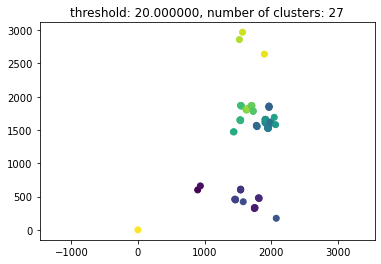

Evaluating 1170.jpg
Evaluating Field
0, 0
18/18 [==============================] - 0s 19ms/step
0, 218
18/18 [==============================] - 0s 19ms/step
0, 436
18/18 [==============================] - 0s 18ms/step
0, 654
18/18 [==============================] - 0s 20ms/step
0, 872
18/18 [==============================] - 0s 18ms/step
0, 1090
18/18 [==============================] - 0s 19ms/step
0, 1308
18/18 [==============================] - 0s 19ms/step
0, 1526
18/18 [==============================] - 0s 18ms/step
0, 1744
18/18 [==============================] - 0s 19ms/step
0, 1962
18/18 [==============================] - 0s 19ms/step
0, 2180
18/18 [==============================] - 0s 18ms/step
0, 2398
18/18 [==============================] - 0s 18ms/step
0, 2616
18/18 [==============================] - 0s 17ms/step
0, 2834
18/18 [==============================] - 0s 19ms/step
0, 3052
18/18 [==============================] - 0s 18ms/step
0, 3270
18/18 [=========================

18/18 [==============================] - 0s 19ms/step
1526, 654
18/18 [==============================] - 0s 18ms/step
1526, 872
18/18 [==============================] - 0s 18ms/step
1526, 1090
18/18 [==============================] - 0s 18ms/step
1526, 1308
18/18 [==============================] - 0s 19ms/step
1526, 1526
18/18 [==============================] - 0s 19ms/step
1526, 1744
18/18 [==============================] - 0s 18ms/step
1526, 1962
18/18 [==============================] - 0s 20ms/step
1526, 2180
18/18 [==============================] - 0s 19ms/step
1526, 2398
18/18 [==============================] - 0s 19ms/step
1526, 2616
18/18 [==============================] - 0s 19ms/step
1526, 2834
18/18 [==============================] - 0s 18ms/step
1526, 3052
18/18 [==============================] - 0s 18ms/step
1526, 3270
18/18 [==============================] - 0s 18ms/step
1526, 3488
18/18 [==============================] - 0s 19ms/step
1526, 3706
10/10 [====================

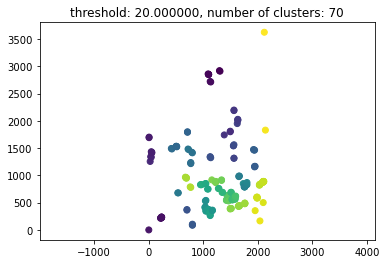

Evaluating 1200.jpg
Evaluating Field
0, 0
18/18 [==============================] - 0s 18ms/step
0, 218
18/18 [==============================] - 0s 19ms/step
0, 436
18/18 [==============================] - 0s 19ms/step
0, 654
18/18 [==============================] - 0s 20ms/step
0, 872
18/18 [==============================] - 0s 19ms/step
0, 1090
18/18 [==============================] - 0s 19ms/step
0, 1308
18/18 [==============================] - 0s 20ms/step
0, 1526
18/18 [==============================] - 0s 19ms/step
0, 1744
18/18 [==============================] - 0s 19ms/step
0, 1962
18/18 [==============================] - 0s 18ms/step
0, 2180
18/18 [==============================] - 0s 18ms/step
0, 2398
18/18 [==============================] - 0s 19ms/step
0, 2616
18/18 [==============================] - 0s 21ms/step
0, 2834
18/18 [==============================] - 0s 17ms/step
0, 3052
18/18 [==============================] - 0s 18ms/step
0, 3270
18/18 [=========================

18/18 [==============================] - 0s 18ms/step
1526, 654
18/18 [==============================] - 0s 18ms/step
1526, 872
18/18 [==============================] - 0s 18ms/step
1526, 1090
18/18 [==============================] - 0s 18ms/step
1526, 1308
18/18 [==============================] - 0s 18ms/step
1526, 1526
18/18 [==============================] - 0s 17ms/step
1526, 1744
18/18 [==============================] - 0s 18ms/step
1526, 1962
18/18 [==============================] - 0s 18ms/step
1526, 2180
18/18 [==============================] - 0s 18ms/step
1526, 2398
18/18 [==============================] - 0s 21ms/step
1526, 2616
18/18 [==============================] - 0s 17ms/step
1526, 2834
18/18 [==============================] - 0s 17ms/step
1526, 3052
18/18 [==============================] - 0s 19ms/step
1526, 3270
18/18 [==============================] - 0s 17ms/step
1526, 3488
18/18 [==============================] - 0s 18ms/step
1526, 3706
10/10 [====================

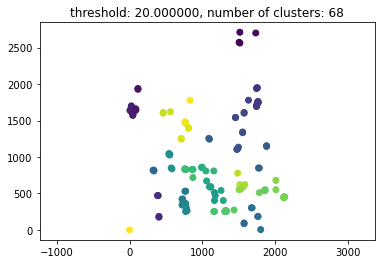

In [8]:
evaluation_pipeline()